# An End-to-End Text Classification System

In this workshop you will implement a text classification system from scratch. This means that we will not rely on Keras' convenient data sets. These data sets are pre-processed and it will be useful if you know how to tokenise and find the word indices of text collections not provided by Keras.

The task will be to classify questions. To run this task we advice that you use [Google Colaboratory](https://colab.research.google.com) (also called Google Colab), which is a cloud solution to run Jupyter notebooks. The demonstrator will show how to use Google Colab. For additional information and to practice with the use of notebooks in Google Colab, you can also follow this link:

* [Welcome notebook and link to additional resources](https://colab.research.google.com/notebooks/welcome.ipynb)

## Question Classification

NLTK has a corpus of questions and their question types according to a particular classification scheme (e.g. DESC refers to a question expecting a descriptive answer, such as one starting with "How"; HUM refers to a question expecting an answer referring to a human). Below is an example of use of the corpus:

In [ ]:
import nltk
nltk.download("qc")
from nltk.corpus import qc
train = qc.tuples("train.txt")
test = qc.tuples("test.txt")

[nltk_data] Downloading package qc to /root/nltk_data...
[nltk_data]   Package qc is already up-to-date!


In [ ]:
train[:3]

[('DESC:manner', 'How did serfdom develop in and then leave Russia ?'),
 ('ENTY:cremat', 'What films featured the character Popeye Doyle ?'),
 ('DESC:manner', "How can I find a list of celebrities ' real names ?")]

In [ ]:
test[:3]

[('NUM:dist', 'How far is it from Denver to Aspen ?'),
 ('LOC:city', 'What county is Modesto , California in ?'),
 ('HUM:desc', 'Who was Galileo ?')]

### Exercise: Find all question types
Write Python code that lists all the possible question types of the training set (**remember: for data exploration, never look at the test set**).


In [ ]:
qtypes = list(set([x for (x,y) in train]))

In [ ]:
qtypes

['DESC:manner',
 'HUM:desc',
 'DESC:reason',
 'LOC:city',
 'ENTY:dismed',
 'NUM:date',
 'NUM:perc',
 'ENTY:event',
 'ENTY:color',
 'ENTY:instru',
 'NUM:money',
 'ENTY:other',
 'HUM:title',
 'ENTY:product',
 'NUM:temp',
 'ENTY:veh',
 'ENTY:letter',
 'ENTY:food',
 'ABBR:abb',
 'NUM:code',
 'ENTY:body',
 'ENTY:currency',
 'ABBR:exp',
 'NUM:speed',
 'ENTY:cremat',
 'NUM:other',
 'LOC:mount',
 'LOC:country',
 'NUM:period',
 'ENTY:substance',
 'ENTY:sport',
 'ENTY:word',
 'DESC:def',
 'NUM:dist',
 'ENTY:plant',
 'NUM:ord',
 'DESC:desc',
 'ENTY:termeq',
 'LOC:state',
 'HUM:gr',
 'LOC:other',
 'ENTY:lang',
 'NUM:weight',
 'ENTY:techmeth',
 'NUM:count',
 'ENTY:animal',
 'NUM:volsize',
 'HUM:ind',
 'ENTY:religion',
 'ENTY:symbol']

### Exercise: Find all general types

The question types have two parts. The first part describes a general type, and the second part defines a subtype. For example, the question type `DESC:manner` belongs to the general `DESC` type and within that type to the `manner` subtype. Let's focus on the general types only. Write Python code that lists all the possible general types (there are 6 of them).

In [ ]:
general_types = list(set([q.split(':')[0] for q in qtypes]))
general_types

['ENTY', 'NUM', 'DESC', 'ABBR', 'HUM', 'LOC']

### Exercise: Partition the data
There is a train and test data, but for this exercise we want to have a partition into train, dev-test, and test. In this exercise, combine all data into one array and do a 3-way partition into train, dev-test, and test. Make sure that you shuffle the data prior to doing the partition. Also, make sure that you only use the general label types.

In [ ]:
qdata = [(qtype.split(':')[0], qstring) for qtype, qstring in train+test]
qdata[:2]

[('DESC', 'How did serfdom develop in and then leave Russia ?'),
 ('ENTY', 'What films featured the character Popeye Doyle ?')]

In [ ]:
import random
random.seed(1234)
random.shuffle(qdata)
threshold1 = int(len(qdata)*.6)
threshold2 = int(len(qdata)*.8)
q_train = qdata[:threshold1]
q_devtest = qdata[threshold1:threshold2]
q_test = qdata[threshold2:]

### Exercise: Tokenise the data

Use Keras' tokeniser to tokenise all the data. For this exercise we will use only the 100 most frequent words in the training set (since you aren't supposed to use the dev-test or test sets to extract features).

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_words = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="[UNK]") # oov_token assigns the code 1 for all unknown words
tokenizer.fit_on_texts([t for l, t in q_train])

In [ ]:
indices_train = tokenizer.texts_to_sequences([t for l, t in q_train])
indices_devtest = tokenizer.texts_to_sequences([t for l, t in q_devtest])
indices_test = tokenizer.texts_to_sequences([[t for l, t in q_test]])

In [ ]:
indices_train[:2]

[[8, 19, 1, 43, 1], [23, 4, 1]]

In [ ]:
q_train[:2]

[('DESC', 'How do ants have sex ?'), ('LOC', 'Where is Guam ?')]

In [ ]:
reverse_word_index = dict((i, w) for w, i in tokenizer.word_index.items())
reverse_word_index[1]

'[UNK]'

In [ ]:
" ".join([reverse_word_index[x] for x in indices_train[0]])

'how do [UNK] have [UNK]'

### Exercise: Vectorize the data
The following code shows the distribution of lengths of my training data (could be different in your training data):

(array([ 328., 1092., 1154.,  615.,  190.,  129.,   48.,   12.,    0.,
           3.]),
 array([ 2. ,  4.8,  7.6, 10.4, 13.2, 16. , 18.8, 21.6, 24.4, 27.2, 30. ]),
 <a list of 10 Patch objects>)

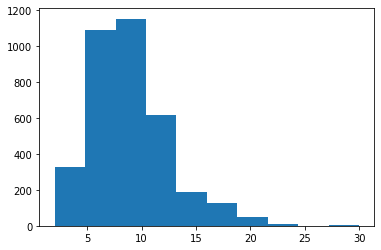

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist([len(d) for d in indices_train])

The histogram shows that the longest question in the training data has 30 word indices, but by far most of the questions have at least 20. Based on this, use Keras' `pad_sequences` to vectorize the questions into sequences of 20 word indices. The default will be to truncate the beginning, but we want to truncate the end (since the first words of a question are often very important to determine the question type). For this you can use the option `truncating='post'`: https://keras.io/preprocessing/sequence/

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 20
x_train = pad_sequences(indices_train, maxlen=maxlen, truncating='post')
x_devtest = pad_sequences(indices_devtest, maxlen=maxlen, truncating='post')
x_test = pad_sequences(indices_test, maxlen=maxlen, truncating='post')

### Exercise: Vectorise the labels
Convert the labels to one-hot encoding. If you use Keras' `to_categorical`, you will first need to convert the labels to integers.

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical([general_types.index(l) for l, t in q_train])
y_devtest = to_categorical([general_types.index(l) for l, t in q_devtest])
y_test = to_categorical([general_types.index(l) for l, t in q_test])

### Exercise: Define the model

Define a model for classification. For this model, use a feedforward architecture with an embedding layer of size 20, a layer that computes the average of word embeddings (use `GlobalAveragePooling1D`), a hidden layer of 16 units, and `relu` activation. You need to determine the size and activation of the output layer.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D

embedding_dim = 20

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            2000      
                                                                 
 global_average_pooling1d (G  (None, 20)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                336       
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 2,438
Trainable params: 2,438
Non-trainable params: 0
_________________________________________________________________


### Exercise: Train and evaluate
Train your model. In the process you need to determine the optimal number of epochs. Then answer the following questions:
1. What was the optimal number of epochs and how did you determine this?
2. Is the system overfitting? Justify your answer.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=500,
                    batch_size=32,
                    validation_data=(x_devtest, y_devtest),
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=2)])

Epoch 1/500
112/112 [==============================] - 2s 9ms/step - loss: 1.7119 - acc: 0.2677 - val_loss: 1.6651 - val_acc: 0.3210
Epoch 2/500
112/112 [==============================] - 1s 6ms/step - loss: 1.6161 - acc: 0.3251 - val_loss: 1.5920 - val_acc: 0.3361
Epoch 3/500
112/112 [==============================] - 1s 5ms/step - loss: 1.5421 - acc: 0.3520 - val_loss: 1.5235 - val_acc: 0.3731
Epoch 4/500
112/112 [==============================] - 1s 8ms/step - loss: 1.4697 - acc: 0.3901 - val_loss: 1.4570 - val_acc: 0.3899
Epoch 5/500
112/112 [==============================] - 1s 5ms/step - loss: 1.3966 - acc: 0.4206 - val_loss: 1.3822 - val_acc: 0.4580
Epoch 6/500
112/112 [==============================] - 0s 4ms/step - loss: 1.3219 - acc: 0.4761 - val_loss: 1.3109 - val_acc: 0.5143
Epoch 7/500
112/112 [==============================] - 1s 5ms/step - loss: 1.2462 - acc: 0.5553 - val_loss: 1.2381 - val_acc: 0.5555
Epoch 8/500
112/112 [==============================] - 0s 4ms/step - 

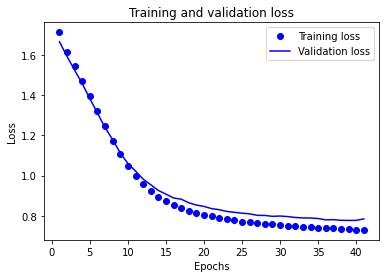

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Based on the validation loss, a good value of epochs is 41. At this point the system is overfitting already but the validation loss appears to be optimal. Let's check with the accuracy as well:

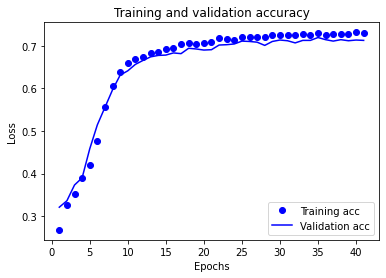

In [ ]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Yes accuracy looks near optimal at 41 epochs.

### Optional Exercise: Data exploration
Plot the distribution of labels in the training data and compare with the distribution of labels in the devtest data. Plot also the distribution of predictions in the devtest data. What can you learn from this?

In [ ]:
from collections import Counter
counter_train_labels = Counter([l for l, t in q_train])
counter_train_labels

Counter({'ABBR': 47,
         'DESC': 806,
         'ENTY': 804,
         'HUM': 737,
         'LOC': 548,
         'NUM': 629})

<BarContainer object of 6 artists>

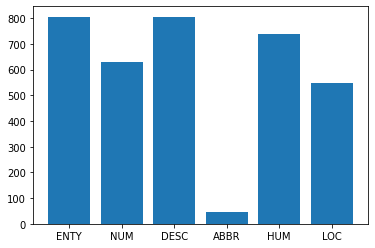

In [ ]:
plt.bar(general_types, [counter_train_labels[l] for l in general_types])

In [ ]:
counter_devtest_labels = Counter([l for l, t in q_devtest])
counter_devtest_labels

Counter({'ABBR': 27,
         'DESC': 256,
         'ENTY': 260,
         'HUM': 275,
         'LOC': 182,
         'NUM': 190})

<BarContainer object of 6 artists>

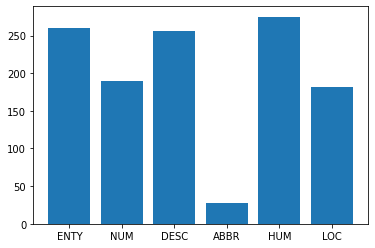

In [ ]:
plt.bar(general_types, [counter_devtest_labels[l] for l in general_types])

The training and devtest sets have similar distributions. The data is somewhat balanced except for the `ABBR` class.

In [ ]:
from numpy import argmax
devtest_predictions_probs = model.predict(x_devtest)
devtest_predictions = [argmax(r) for r in devtest_predictions_probs]
devtest_predictions_labels = [general_types[i] for i in devtest_predictions]

In [ ]:
counter_devtest_predictions = Counter(devtest_predictions_labels)
counter_devtest_predictions

Counter({'DESC': 262, 'ENTY': 362, 'HUM': 258, 'LOC': 156, 'NUM': 152})

<BarContainer object of 6 artists>

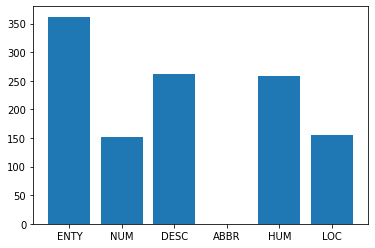

In [ ]:
plt.bar(general_types, [counter_devtest_predictions[l] for l in general_types])

The predicted labels have a different distribution to the labels of the training and devtest data, and there are no predictions for the ABBR class. This is a common issue. Sometimes, the system does not learn classes that have poor representation in the training data.

### Optional Exercise: Improve your system

Try the following options:

1. Use pre-trained word embeddings
2. Use recurrent neural networks.

Feel free to try each option separately and in combination, and compare the results. Feel also free to try with other variants of the initial architecture, such as:

1. Introducing more hidden layers.
2. Changing the size of embeddings.
3. Changing the number of units in the hidden layer(s).